# Import libraries

In [179]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tools.eval_measures import rmse
from statsmodels.graphics.tsaplots import plot_pacf

from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

from sklearn.model_selection import ParameterGrid, TimeSeriesSplit, RandomizedSearchCV, GridSearchCV

from xgboost import XGBRegressor

# Load data

In [180]:
df = pd.read_csv(
     "All Time Series (1) (1).csv"
    )

# df.drop("ID", axis = 1, inplace = True)
df["DATE"] = pd.to_datetime(df["DATE"], format = "%Y-%m-%d")
df.set_index(df["DATE"], inplace = True)
df.drop("DATE", axis = 1, inplace = True)
df

,'JobType_001','JobType_002','JobType_003','JobType_004','JobType_005','JobType_006','JobType_007','JobType_008','JobType_009','JobType_010',...,'JobType_667','JobType_668','JobType_669','JobType_670','JobType_671','JobType_672','JobType_673','JobType_674','JobType_675','JobType_676'
DATE,,,,,,,,,,,,,,,,,,,,,
2023-01-01,NaN,746261,NaN,240578,NaN,2184116,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-02,NaN,171966,NaN,27372,NaN,434023,NaN,NaN,NaN,8526.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-03,NaN,757439,NaN,232885,NaN,1552331,NaN,NaN,NaN,66699.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-04,NaN,900697,NaN,120853,NaN,1499278,NaN,NaN,NaN,120513.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-05,7458.0,642536,NaN,79600,NaN,1370149,NaN,NaN,NaN,119581.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,1432014.0,854859,438820.0,50515,1266739.0,192396,245056.0,301575.0,216272.0,396935.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-28,1399398.0,584451,1790787.0,115282,712286.0,299742,82746.0,254650.0,360911.0,440431.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-29,8648577.0,926468,1063989.0,474476,414152.0,271076,213018.0,397015.0,836265.0,187.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Check for missing date labels

In [181]:
pd.date_range(df.index.min(), df.index.max(), freq="D").difference(df.index)

DatetimeIndex([], dtype='datetime64[ns]', freq='D')

### Set datetime index frequency

In [182]:
# df.index.freq = "H"
df.index

DatetimeIndex(['2023-01-01', '2023-01-02', '2023-01-03', '2023-01-04',
               '2023-01-05', '2023-01-06', '2023-01-07', '2023-01-08',
               '2023-01-09', '2023-01-10',
               ...
               '2023-12-22', '2023-12-23', '2023-12-24', '2023-12-25',
               '2023-12-26', '2023-12-27', '2023-12-28', '2023-12-29',
               '2023-12-30', '2023-12-31'],
              dtype='datetime64[ns]', name='DATE', length=365, freq=None)

### Check for missing values

In [183]:
df.isnull().sum()

'JobType_001'      8
'JobType_002'      0
'JobType_003'     20
'JobType_004'      0
'JobType_005'     75
                ... 
'JobType_672'    364
'JobType_673'    364
'JobType_674'    364
'JobType_675'    364
'JobType_676'    364
Length: 676, dtype: int64

In [184]:
df = df[["'JobType_002'"]]

In [185]:
df

,'JobType_002'
DATE,
2023-01-01,746261
2023-01-02,171966
2023-01-03,757439
2023-01-04,900697
2023-01-05,642536
...,...
2023-12-27,854859
2023-12-28,584451
2023-12-29,926468


# Train, Test split

In [186]:
train, test = df.loc[ : "2023-09-30"].copy(), df.loc["2023-10-01":].copy()
print(train.shape)
print(test.shape)

(273, 1)
(92, 1)


In [187]:
train

,'JobType_002'
DATE,
2023-01-01,746261
2023-01-02,171966
2023-01-03,757439
2023-01-04,900697
2023-01-05,642536
...,...
2023-09-26,312812
2023-09-27,315047
2023-09-28,237189


In [188]:
test

,'JobType_002'
DATE,
2023-10-01,1523955
2023-10-02,1034804
2023-10-03,1759128
2023-10-04,300727
2023-10-05,410077
...,...
2023-12-27,854859
2023-12-28,584451
2023-12-29,926468


# Explore data

### Stationarity Check

Seasonal Decomposition

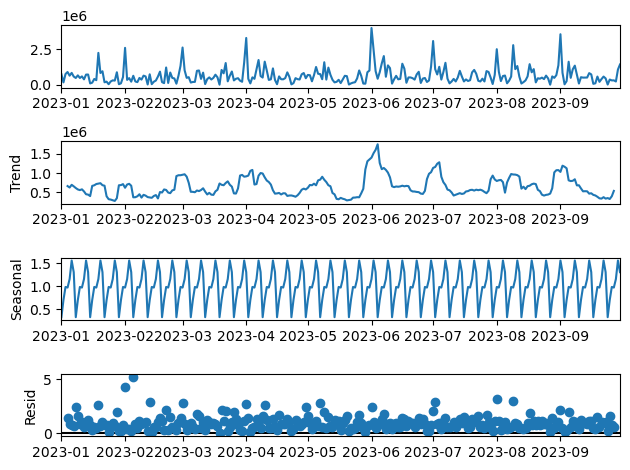

In [189]:
seasonal_decompose(train, model = "multiplicative").plot();
# multiplicative model: seasonality increases with time

Augmented Dickey-Fuller Test

In [190]:
def adf_test(series, title = " "):
    """
        Pass in a timeseries and an optional title, returns an ADF report
    """
    print(f"Augmented Dickey-Fuller test {title}")

    result = adfuller(series.dropna(), autolag = "AIC") #dropna handles differenced data
    labels = ["ADF test statistics", "pvalue", "# of lags used", "# of observations"]
    out = pd.Series(result[0:4], index = labels)

    for key, val in result[4].items():
        out[f"Critical Value ({key})"] = val

    if result[1] <= 0.05:
        print("Strong evidence against null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

    print(out.to_string())

adf_test(train["'JobType_002'"])

Augmented Dickey-Fuller test  
Strong evidence against null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary
ADF test statistics    -1.122522e+01
pvalue                  1.968197e-20
# of lags used          1.000000e+00
# of observations       2.710000e+02
Critical Value (1%)    -3.454713e+00
Critical Value (5%)    -2.872265e+00
Critical Value (10%)   -2.572485e+00


kpss test

In [191]:
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c', nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','#Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    if kpss_output["p-value"] < 0.05:
      print("Data is non-stationary. Reject null hypothesis")
    else:
      print("Data is stationary. No evidence against null hypothesis")
    print (kpss_output)

kpss_test(train["'JobType_002'"])

Results of KPSS Test:
Data is stationary. No evidence against null hypothesis
Test Statistic           0.149272
p-value                  0.100000
#Lags Used               1.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


Rolling mean and statndard deviation

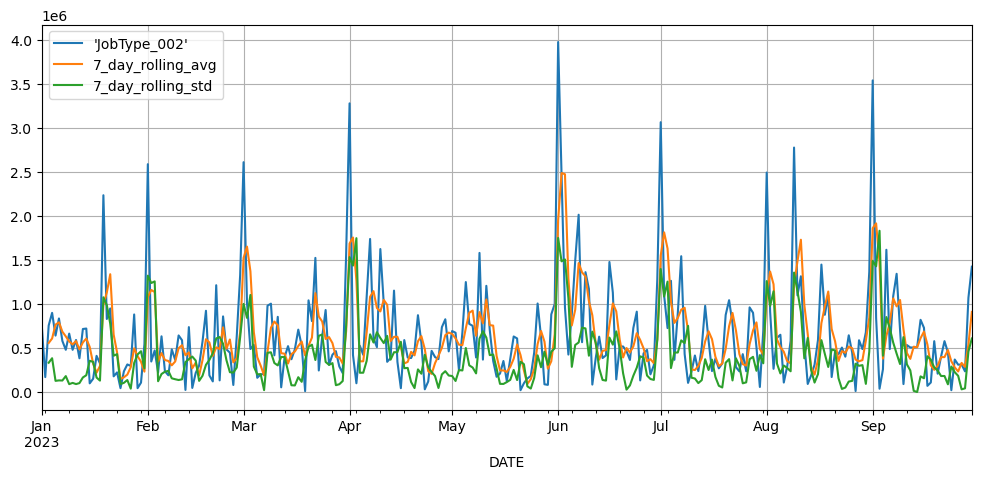

In [192]:
train["7_day_rolling_avg"] = train["'JobType_002'"].rolling(3).mean()
train["7_day_rolling_std"] = train["'JobType_002'"].rolling(3).std()

train["'JobType_002'"].plot.line(legend = True, figsize = (12, 5))
train["7_day_rolling_avg"].plot.line(legend = True, grid = True)
train["7_day_rolling_std"].plot.line(legend = True, grid = True);

train.drop(["7_day_rolling_avg", "7_day_rolling_std"], axis = 1, inplace = True)

### It appears data is stationary

In [193]:
test

,'JobType_002'
DATE,
2023-10-01,1523955
2023-10-02,1034804
2023-10-03,1759128
2023-10-04,300727
2023-10-05,410077
...,...
2023-12-27,854859
2023-12-28,584451
2023-12-29,926468


### Determine Seasonality

Plot any 3 weeks of data

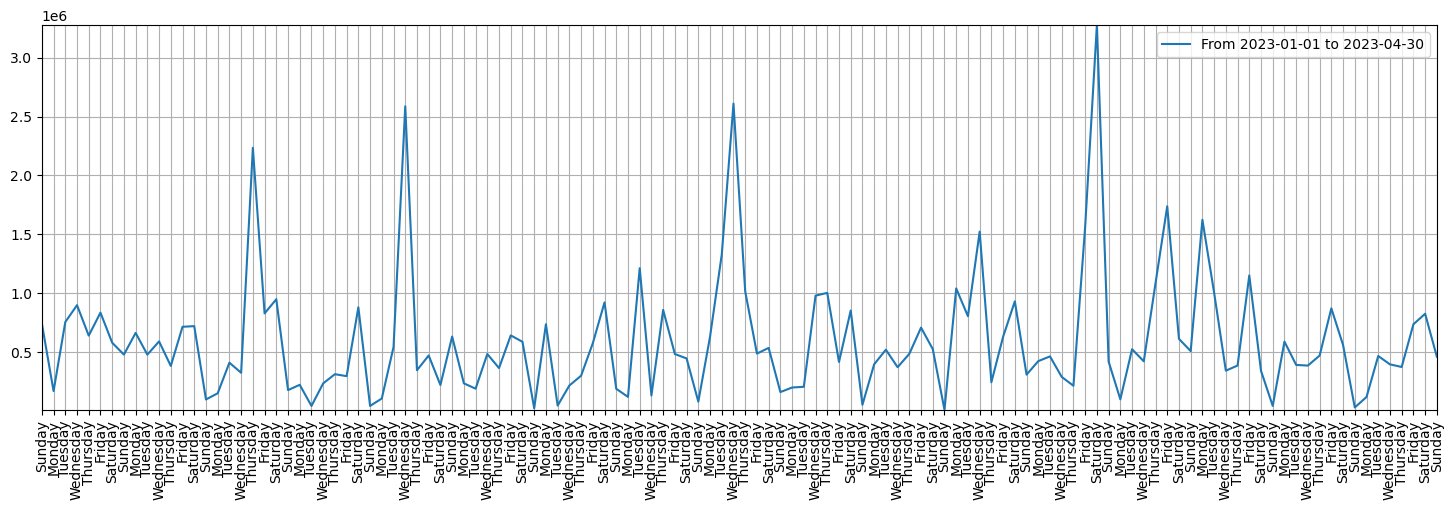

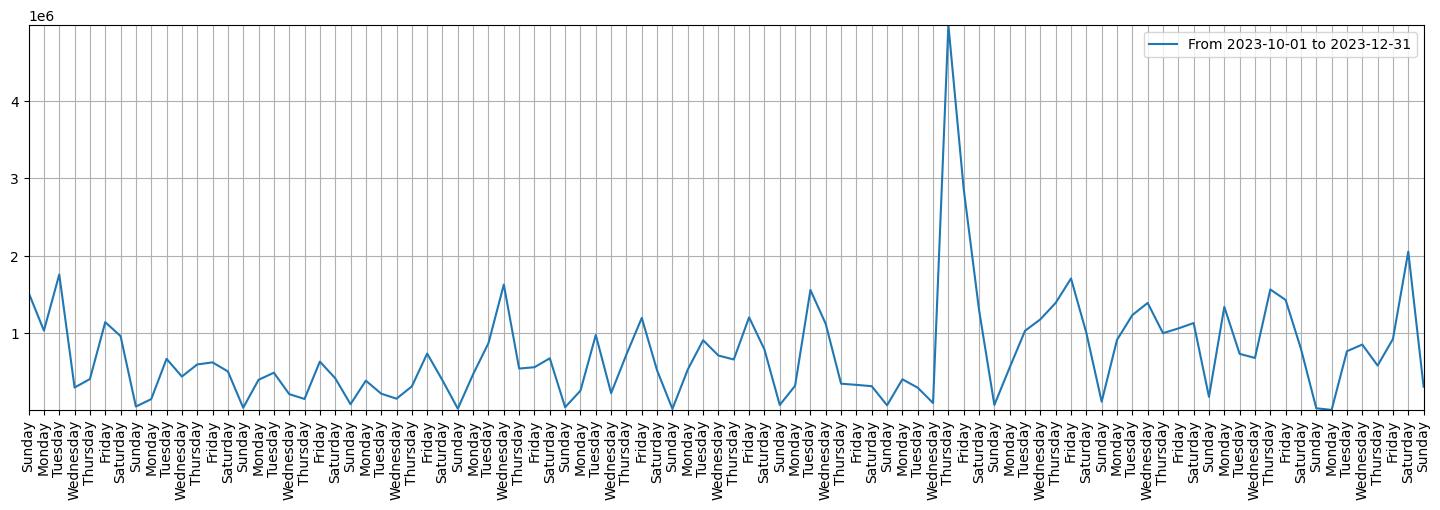

In [194]:
def plot_date_range(data, start, end):

  data = data.loc[start : end].copy()
  xticks = list(pd.to_datetime(data.index.date).unique())
  xlabels = list(pd.to_datetime(data.index.date).unique().strftime("%A"))
  figure, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (18, 5))
  ax.plot(data.index, data["'JobType_002'"], label = "From {} to {}".format(start, end))
  ax.set_xticks(xticks)
  ax.set_xticklabels(xlabels, rotation = 90)
  ax.grid(True)
  ax.legend()
  ax.autoscale(enable = True, axis = "both", tight = True)
  plt.show()
  del data

plot_date_range(train, "2023-01-01", "2023-04-30")
plot_date_range(test, "2023-10-01", "2023-12-31")


### Data distribution check for sesonality

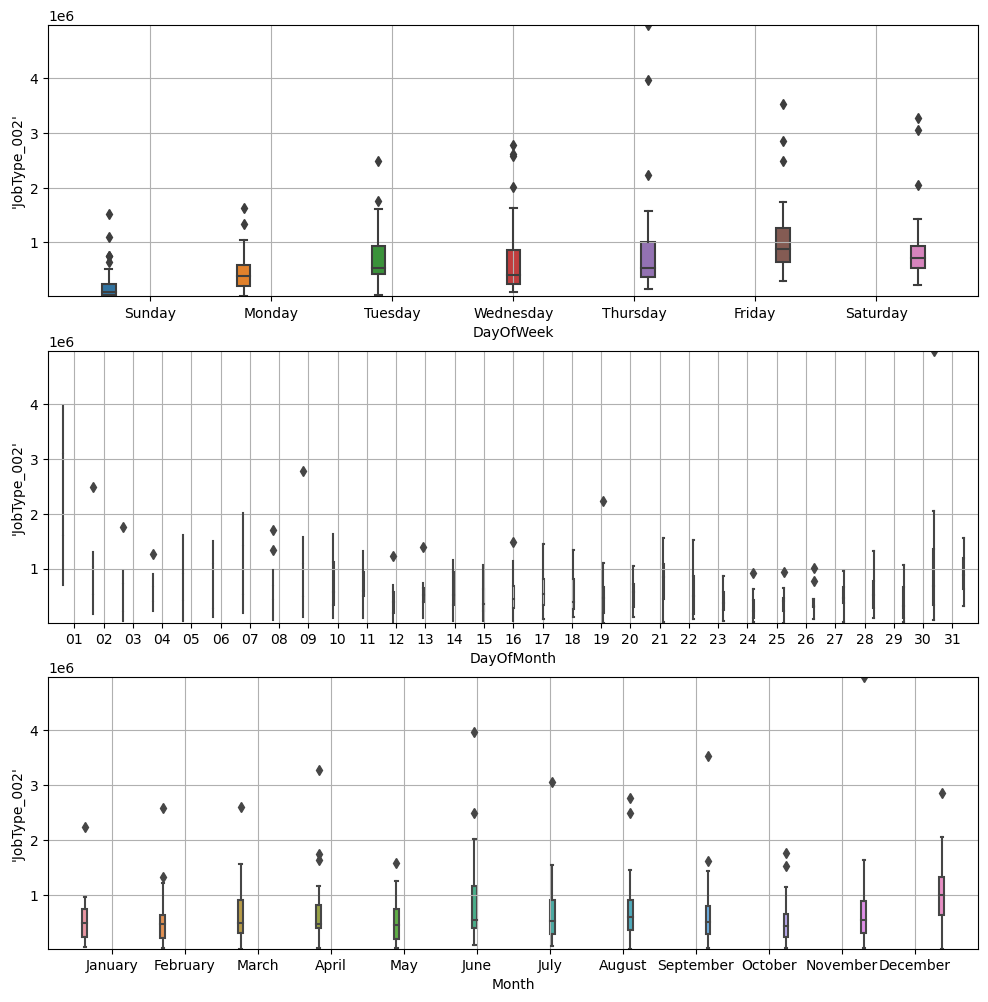

In [195]:
def check_distribution_by_time_periods(data):

  ########################################################################################################################################

#   data["HourOfDay"] = data.index.hour
  df["DayOfWeek"] = pd.to_datetime(df.index.date).strftime("%A")
  df["DayOfMonth"] = pd.to_datetime(df.index.date).strftime("%d")
  df["Month"] = pd.to_datetime(df.index.date).month_name()


  ########################################################################################################################################

  weekdays =  ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]
  months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]


  ########################################################################################################################################

  fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize = (12, 12))
#   sns.boxplot(data, x = "HourOfDay", y = "'JobType_002'", hue = "HourOfDay", ax = ax[0])
  sns.boxplot(df, x = "DayOfWeek", y = "'JobType_002'", hue = "DayOfWeek", order = weekdays, ax = ax[0])
  sns.boxplot(df, x = "DayOfMonth", y = "'JobType_002'", hue = "DayOfMonth", order = df.loc["2023-12-01" : "2023-12-31"]["DayOfMonth"].sort_values(ascending = True), ax = ax[1])
  sns.boxplot(df, x = "Month", y = "'JobType_002'", hue = "Month", order = months, ax = ax[2])

  for a in ax:
    a.autoscale(enable = True, axis = "both", tight = True)
    a.grid(True)
    a.legend([],[], frameon=False)

  df.drop(["DayOfWeek", "Month","DayOfMonth"], axis = 1, inplace = True)


check_distribution_by_time_periods(train)

It appears daily, weekly, yearly seasonalities are present

# Modelling

### Holt-Winters method

Obtain optimized paramerts for Holt-Winter's method

In [196]:
def holt_winters_optimized_parameters(train_ser, test_ser, seasonal_periods):
    trend = ["add", "mul"]
    seasonal = ["add", "mul"]

    low_rmse = 9999999999
    for t in trend:
        for s in seasonal:
            model = ExponentialSmoothing(endog = train_ser , trend = t, seasonal = s, seasonal_periods = seasonal_periods)
            fit_model = model.fit()
            test_predictions = fit_model.forecast(len(test))
            error = rmse(test_ser, test_predictions)

            if error < low_rmse:
                best_trend = t
                best_seasonal = s
                low_rmse = error


    return (best_trend, best_seasonal, low_rmse)

# There are at-least three types of seasonalities presesnt. A value of 24*7 does not entirely capture this
best_trend, best_seasonal, low_rmse = holt_winters_optimized_parameters(train["'JobType_002'"], test["'JobType_002'"], 12)
print("Best trend {}, best seasonal {}".format(best_trend, best_seasonal))
print("RMSE: ", str(round(low_rmse, 4)))

Best trend add, best seasonal mul
RMSE:  729014.5649


Train a Holt-Winters model and predict

In [197]:
def holt_winters_prediction(train_ser, test_ser, best_trend, best_seasonal, seasonal_periods):

    model = ExponentialSmoothing(endog = train_ser, trend = best_trend, seasonal = best_seasonal, seasonal_periods = seasonal_periods)
    fit_model = model.fit()
    test_predictions = round(fit_model.forecast(len(test)), 0)

    mape = str(round(np.mean(np.abs(test_ser - test_predictions) / test_ser) * 100, 4))
    error_rms = str(round(rmse(test_ser, test_predictions), 4))
    title = "RMSE: " + error_rms + ". Test Mean: " + str(round(test_ser.mean(), 4)) + ". MAPE : " + mape

    test_predictions.index.name = "Datetime"
    test_predictions = test_predictions.to_frame(name = "Count")

    fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, figsize = (20, 8))
    ax1.plot(train_ser, label = "train")
    ax1.plot(test_ser, label = "test")
    ax1.plot(test_predictions, label = "predictions")
    ax1.legend()
    ax1.set_title(title)
    ax1.autoscale(enable = True, axis = "both", tight = True)
    ax1.grid(True)

    ax2.plot(test_ser, label = "actuals")
    ax2.plot(test_predictions, label = "predictions")
    ax2.legend()
    ax2.grid(True)
    ax2.set_title("Forecast vs Actuals: " + title)
    #ax2.set_xticks(pd.to_datetime(test.index.date).unique())
    #ax2.set_xticklabels(ax2.get_xticklabels(), rotation = 90)
    ax2.autoscale(enable = True, axis = "both", tight = True)

    plt.show()

    return error_rms, mape, test_predictions, model

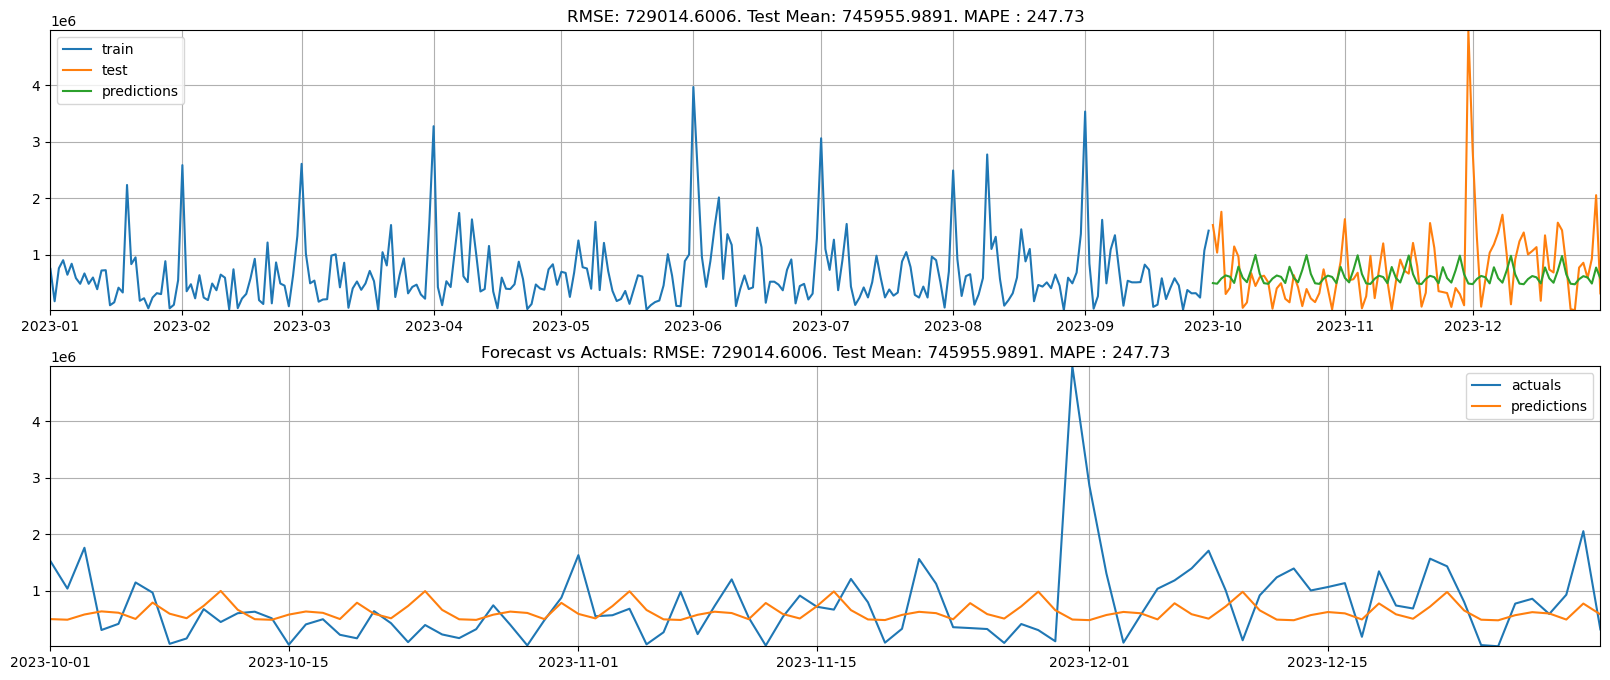

,Model_Name,rmse,mape
0,Holt-Winter's,729014.6006,247.73


In [198]:
error_rms, mape, predictions, _ = holt_winters_prediction(train["'JobType_002'"], test["'JobType_002'"], best_trend, best_seasonal, 12)
evaluation_dict = dict()
evaluation_dict["Model_Name"] = ["Holt-Winter's"]
evaluation_dict["rmse"] = [error_rms]
evaluation_dict["mape"] = [mape]
df_evaluation = pd.DataFrame(evaluation_dict)
df_evaluation

### Prophet

Data preprocessing for Prophet

In [199]:
# df = pd.read_csv(
#      "/content/drive/MyDrive/DataSource/Train_SU63ISt.csv"
#     )

# df.drop("ID", axis = 1, inplace = True)
# df["Datetime"] = pd.to_datetime(df["Datetime"], format = "%d-%m-%Y %H:%M")
# df.columns = ["ds", "y"]
# df

In [200]:
train = train.reset_index()
train.columns = ['ds','y']
test = test.reset_index()
test.columns = ['ds','y']

In [201]:
train

,ds,y
0,2023-01-01,746261
1,2023-01-02,171966
2,2023-01-03,757439
3,2023-01-04,900697
4,2023-01-05,642536
...,...,...
268,2023-09-26,312812
269,2023-09-27,315047
270,2023-09-28,237189
271,2023-09-29,1072463


Train, test split

In [202]:
# train, test = df[df["ds"] < "2014-09-01"], df[df["ds"] >= "2014-09-01"]
print(train.shape)
print(test.shape)

(273, 2)
(92, 2)


In [203]:
train

,ds,y
0,2023-01-01,746261
1,2023-01-02,171966
2,2023-01-03,757439
3,2023-01-04,900697
4,2023-01-05,642536
...,...,...
268,2023-09-26,312812
269,2023-09-27,315047
270,2023-09-28,237189
271,2023-09-29,1072463


In [204]:
test

,ds,y
0,2023-10-01,1523955
1,2023-10-02,1034804
2,2023-10-03,1759128
3,2023-10-04,300727
4,2023-10-05,410077
...,...,...
87,2023-12-27,854859
88,2023-12-28,584451
89,2023-12-29,926468
90,2023-12-30,2053816


Train and predict with a baseline Prophet model

In [205]:
def prophet_prediction(train_df, test_df, freq, **kwargs):

    if kwargs == {}:
        model = Prophet()
        print("No parameters provided")
    else:
        print("Parameters provided")
        model = Prophet(
                 changepoint_prior_scale  = kwargs["kwargs"]["changepoint_prior_scale"].values[0]
                ,seasonality_mode = kwargs["kwargs"]["seasonality_mode"].values[0]
                ,seasonality_prior_scale = kwargs["kwargs"]["seasonality_prior_scale"].values[0]
                ,yearly_seasonality = False  #Turning it off gives better RMSE
                ,weekly_seasonality = True
                ,daily_seasonality = True
        )

    model.fit(train_df)
    future = model.make_future_dataframe(periods = len(test_df), freq = freq)
    test_predictions = model.predict(future)

    test_predictions = test_predictions.iloc[len(test_df)*-1:]
    test_predictions["yhat"] = round(test_predictions["yhat"], 0)

    test_df["y"]
    test_predictions.reset_index(drop=True, inplace=True)
    test_df.reset_index(drop=True, inplace=True)
#     print(test_predictions["yhat"] - test_df["y"].astype(float))
    mape = str(round(np.mean(np.abs(test_predictions["yhat"] - test_df["y"].astype(float)) / test_df["y"].astype(float)) * 100, 4))
    error_rms = str(round(rmse(test_predictions["yhat"], test_df["y"]), 4))
    title = "RMSE: " + error_rms + " - Test mean: " + str(round(test_df["y"].mean(), 4)) + " - MAPE: " + mape

    fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, figsize = (20, 8))
    ax1.plot(train_df["ds"], train_df["y"], label = "train")
    ax1.plot(test_df["ds"], test_df["y"], label = "test")
    ax1.plot(test_predictions["ds"], test_predictions["yhat"], label = "predictions")
    ax1.legend()
    ax1.set_title(title)
    ax1.autoscale(enable = True, axis = "both", tight = True)
    ax1.grid(True)

    ax2.plot(test_df["ds"], test_df["y"], label = "actuals")
    ax2.plot(test_predictions["ds"], test_predictions["yhat"], label = "predictions")
    ax2.legend()
    ax2.grid(True)
    ax2.set_title("Forecast vs Actuals: " + title)
    ax2.autoscale(enable = True, axis = "both", tight = True)

    plt.show()

    model.plot_components(test_predictions)
    print('mape')
    print(mape)

    return error_rms, mape, test_predictions, model



17:52:13 - cmdstanpy - INFO - Chain [1] start processing


No parameters provided


17:52:14 - cmdstanpy - INFO - Chain [1] done processing


0    -1252852.0
1     -568912.0
2    -1049725.0
3      410629.0
4      382727.0
        ...    
87    -118525.0
88     233331.0
89     152297.0
90   -1147482.0
91     -13442.0
Length: 92, dtype: float64


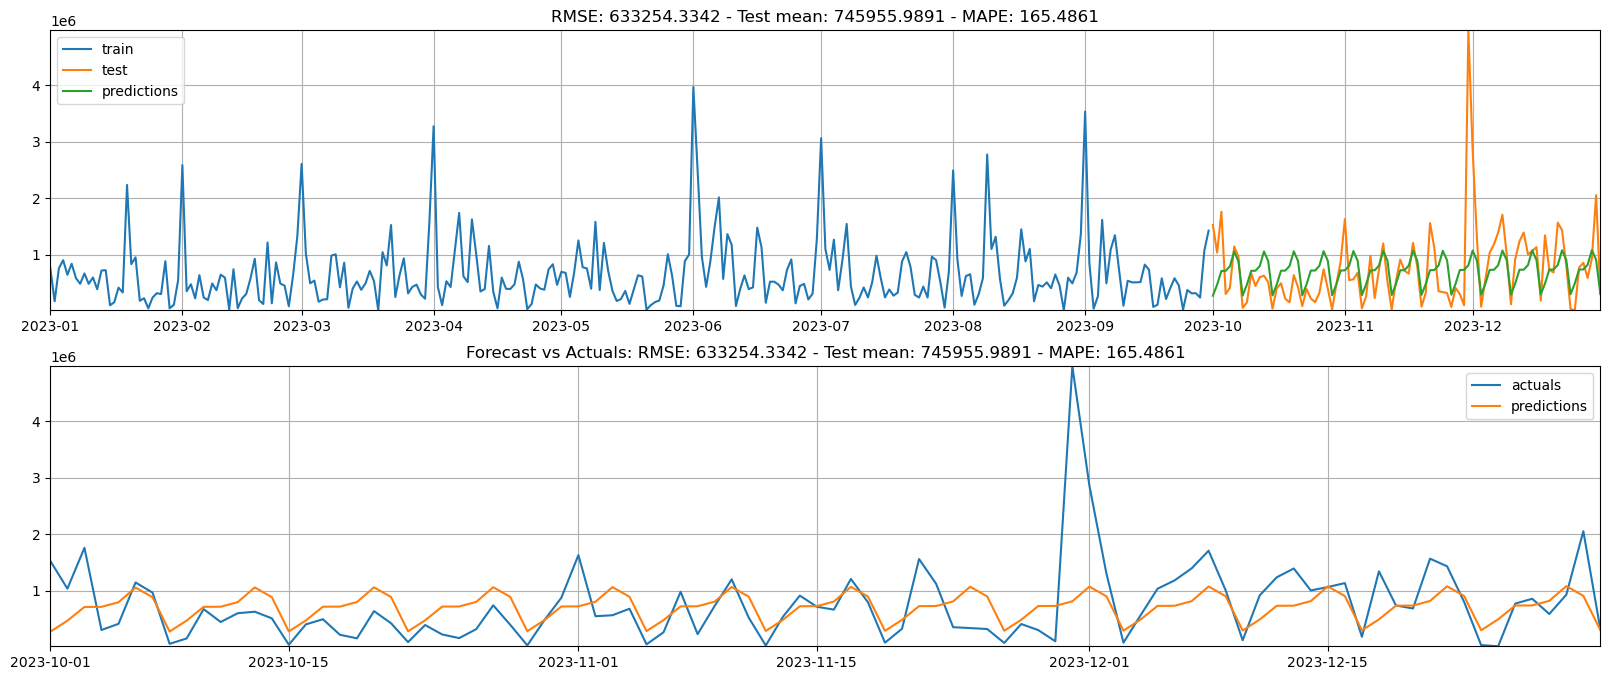

mape
165.4861


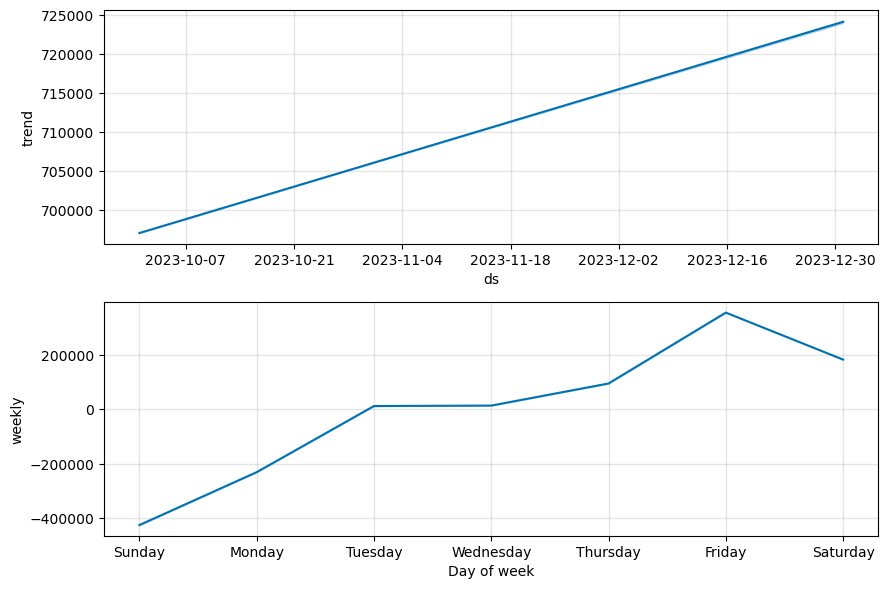

In [206]:
error_rms, mape, predictions, _ = prophet_prediction(train, test, "D")
df_evaluation = pd.concat(
    [
        df_evaluation
        ,pd.DataFrame(
            data = {"Model_Name" : "Baseline Prophet", "rmse" : error_rms, "mape" : mape}
            ,index = [1]
            )
    ]
    ,axis = 0
)

In [207]:
df_evaluation

,Model_Name,rmse,mape
0,Holt-Winter's,729014.6006,247.73
1,Baseline Prophet,633254.3342,165.4861


In [243]:
def prophet_hyperparameter_tuning(train):
    param_grid = {
        "seasonality_mode" : ["additive", "multiplicative"]
        ,"seasonality_prior_scale" : [1, 5, 10, 20]
        ,"changepoint_prior_scale" : [0.005, 0.01, 0.05, 0.1]
    }

    grid = ParameterGrid(param_grid)
    print("Training {} models".format(len(list(grid))))

    error = []
    for params in tqdm(grid):
        m = Prophet(
             seasonality_mode = params["seasonality_mode"]
            ,seasonality_prior_scale = params["seasonality_prior_scale"]
            ,changepoint_prior_scale = params["changepoint_prior_scale"]
            ,yearly_seasonality = True
            ,weekly_seasonality = True
            ,daily_seasonality = True
        )
        m.fit(train)
        df_cv = cross_validation(m, initial='200 days', horizon = '30 days', parallel = "processes")
        df_p = performance_metrics(df_cv)
        error.append(df_p["rmse"].mean())

    tuning_results = pd.DataFrame(grid)
    tuning_results["rmse"] = error
    best_params = tuning_results[tuning_results["rmse"] == tuning_results["rmse"].min()]
    return best_params

In [244]:
best_params = prophet_hyperparameter_tuning(train)

Training 32 models


  0%|          | 0/32 [00:00<?, ?it/s]18:08:48 - cmdstanpy - INFO - Chain [1] start processing
18:08:48 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  3%|▎         | 1/32 [00:09<05:02,  9.75s/it]18:08:58 - cmdstanpy - INFO - Chain [1] start processing
18:08:58 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  6%|▋         | 2/32 [00:17<04:09,  8.31s/it]18:09:05 - cmdstanpy - INFO - Chain [1] start processing
18:09:05 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  9%|▉         | 3/32 [00:24<03:43,  7.72s/it]18:09:12 - cmdstanpy - INFO - Chain [1] start processing
18:09:12 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than i

 97%|█████████▋| 31/32 [06:27<00:08,  8.78s/it]18:15:16 - cmdstanpy - INFO - Chain [1] start processing
18:15:16 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
100%|██████████| 32/32 [06:34<00:00, 12.34s/it]


In [245]:
best_params

,changepoint_prior_scale,seasonality_mode,seasonality_prior_scale,rmse
12,0.01,multiplicative,1,662033.188754


Parameters provided


18:39:26 - cmdstanpy - INFO - Chain [1] start processing
18:39:26 - cmdstanpy - INFO - Chain [1] done processing


0    -1258084.0
1     -556274.0
2    -1012010.0
3      422425.0
4      415715.0
        ...    
87     -89442.0
88     289572.0
89     271183.0
90   -1080708.0
91     -28864.0
Length: 92, dtype: float64


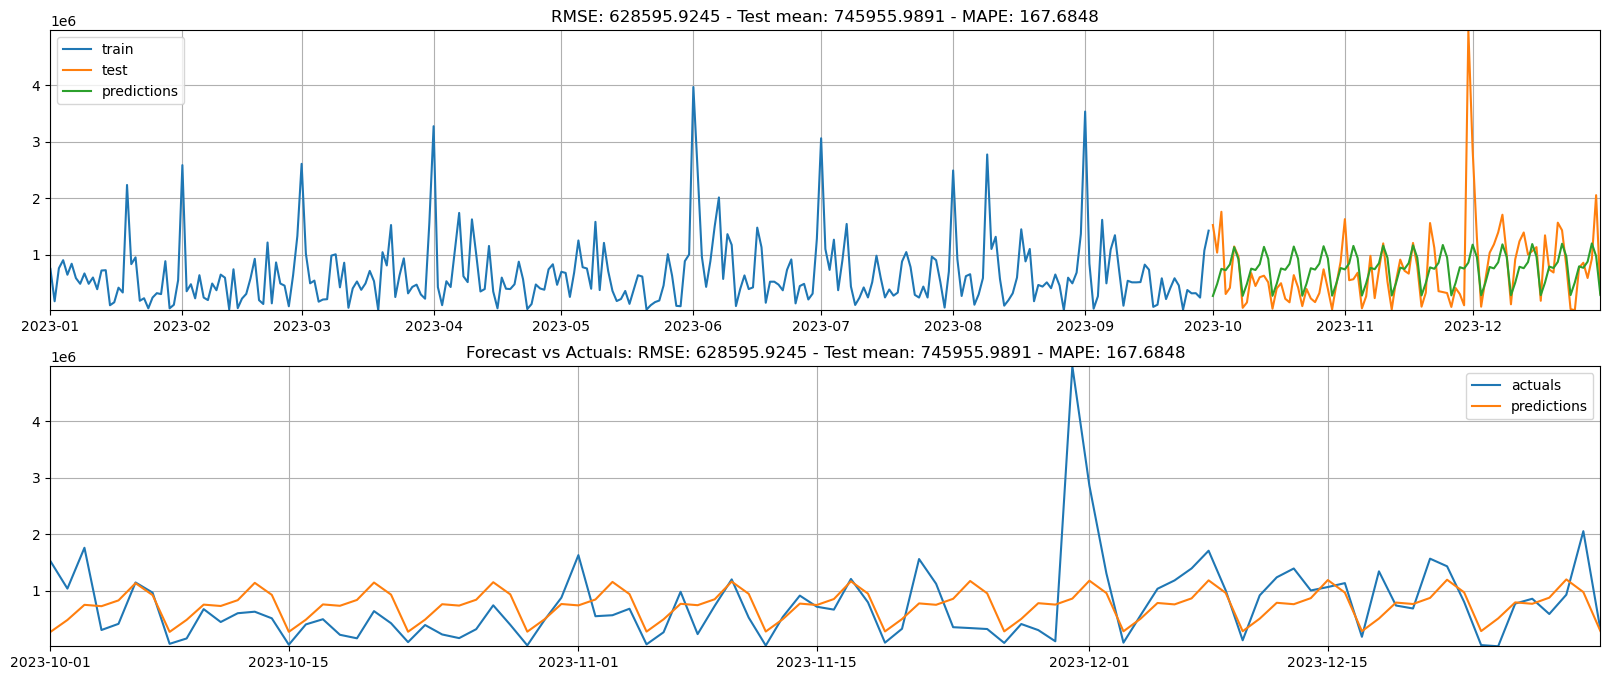

mape
167.6848


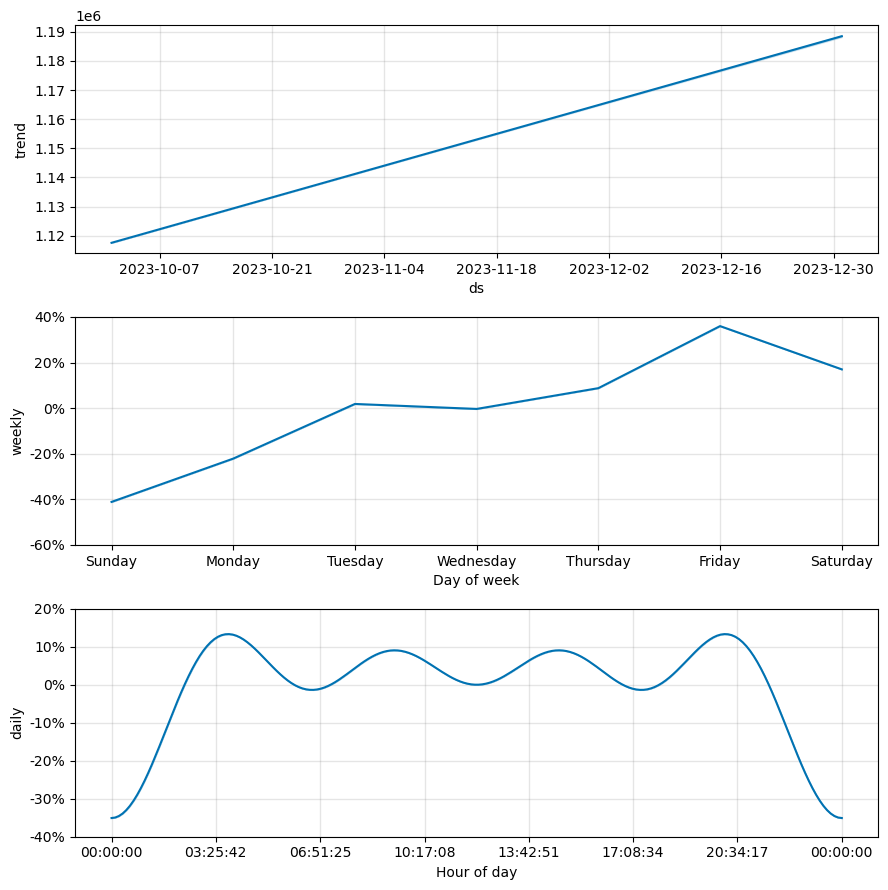

In [247]:
error_rms, mape, predictions, _ = prophet_prediction(train, test, "D", kwargs = best_params)
df_evaluation = pd.concat(
    [
        df_evaluation
        ,pd.DataFrame(
            data = {"Model_Name" : "Parameter Tuned Prophet", "rmse" : error_rms, "mape" : mape}
            ,index = [2]
            )
    ]
    ,axis = 0
)

In [248]:
df_evaluation

,Model_Name,rmse,mape
0,Holt-Winter's,729014.6006,247.73
1,Baseline Prophet,633254.3342,165.4861
2,Parameter Tuned Prophet,699024.0829,408.3778
2,Parameter Tuned Prophet,628595.9245,167.6848


In [249]:
predictions[["ds", "yhat"]]

,ds,yhat
0,2023-10-01,265871.0
1,2023-10-02,478530.0
2,2023-10-03,747118.0
3,2023-10-04,723152.0
4,2023-10-05,825792.0
...,...,...
87,2023-12-27,765417.0
88,2023-12-28,874023.0
89,2023-12-29,1197651.0
90,2023-12-30,973108.0


# Machine Learning Model - XGBoost

### Pepare data

In [250]:
train.set_index(train["ds"], inplace = True)
train.drop("ds", axis = 1, inplace = True)
train

,y
ds,
2023-01-01,746261
2023-01-02,171966
2023-01-03,757439
2023-01-04,900697
2023-01-05,642536
...,...
2023-09-26,312812
2023-09-27,315047
2023-09-28,237189


In [252]:
test.set_index(test["ds"], inplace = True)
test.drop("ds", axis = 1, inplace = True)
test

,y
ds,
2023-10-01,1523955
2023-10-02,1034804
2023-10-03,1759128
2023-10-04,300727
2023-10-05,410077
...,...
2023-12-27,854859
2023-12-28,584451
2023-12-29,926468


### Train, test split

In [ ]:
# train, test = df.loc[ : "2014-08-31"].copy(), df.loc["2014-09-01":].copy()
# print(train.shape)
# print(test.shape)

In [253]:
train

,y
ds,
2023-01-01,746261
2023-01-02,171966
2023-01-03,757439
2023-01-04,900697
2023-01-05,642536
...,...
2023-09-26,312812
2023-09-27,315047
2023-09-28,237189


In [254]:
test

,y
ds,
2023-10-01,1523955
2023-10-02,1034804
2023-10-03,1759128
2023-10-04,300727
2023-10-05,410077
...,...
2023-12-27,854859
2023-12-28,584451
2023-12-29,926468


### Explore data
- Prepare a partial Auto-Corelation plot to select lagged features for XGBoost
- Let's begin with selecting first lag as per the below diagram

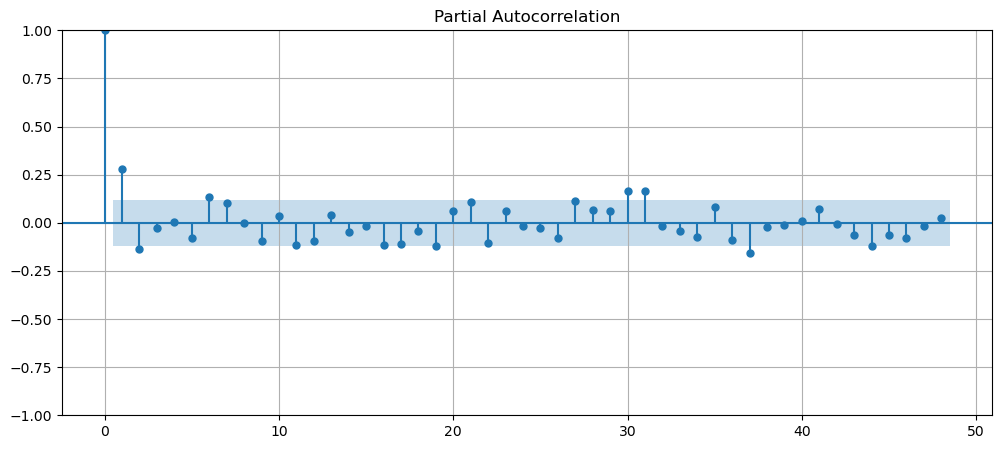

In [255]:
fig, ax = plt.subplots(figsize = (12, 5))
plot_pacf(train, lags = 48, ax = ax);
ax.grid(True)
plt.show()

### Preprocess data

In [256]:
def create_features_for_xgboost(data, target_var_name, lags = 0):

  #These values will behave like ordinal encoded values
  data["Month"] = data.index.month
  data["DayofMonth"] = data.index.day
  data["Weekday"] = data.index.weekday
  data["HourOfDay"] = data.index.hour

  #xgboost will handle missing values
  for l in range(1, (lags + 1)):
    data["lag_{}".format(l)] = data[target_var_name].shift(l)

  X = data.drop(target_var_name, axis = 1)
  y = data[target_var_name]

  return X, y

In [258]:
X_train, y_train = create_features_for_xgboost(train, "y", 1)
X_test, y_test = create_features_for_xgboost(test, "y", 1)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(273, 5)
(273,)
(92, 5)
(92,)


Train a baseline XGBRegressor model and predict

In [259]:
def xgboost_prediction(X_train, y_train, X_test, y_test, **kwargs):


  #########################################################################################################

  if kwargs == {}:
    print("No parameters")
    model = XGBRegressor()

  else:
    print("Parameters provided")
    model = XGBRegressor(
      max_depth = kwargs["kwargs"]["max_depth"].values[0]
      ,learning_rate = kwargs["kwargs"]["learning_rate"].values[0]
      ,n_estimators = kwargs["kwargs"]["n_estimators"].values[0]
      ,colsample_bytree = kwargs["kwargs"]["colsample_bytree"].values[0]
    )

  #########################################################################################################
  model.fit(X_train, y_train)
  test_predictions = model.predict(X_test)
  test_predictions = pd.DataFrame(data = test_predictions, index = y_test.index, columns = ["Count"])
  test_predictions["Count"] = np.round(test_predictions["Count"])

  #########################################################################################################

  mape = str(round(np.mean(np.abs(y_test - test_predictions.iloc[:, 0]) / y_test) * 100, 4))
  error_rms = str(round(rmse(y_test, test_predictions.iloc[:, 0]), 4))
  title = "RMSE: " + error_rms + ". Test Mean: " + str(round(y_test.mean(), 4)) + ". MAPE : " + mape

  #########################################################################################################

  feature_importance = model.get_booster().get_score(importance_type = "weight")
  keys = list(feature_importance.keys())
  values = list(feature_importance.values())

  data = pd.DataFrame(data = values, index = keys, columns = ["Score"]).sort_values(by = "Score", ascending = True)
  data.plot.barh(figsize = (12, 4));

  #########################################################################################################

  fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, figsize = (20, 8))
  ax1.plot(y_train, label = "train")
  ax1.plot(y_test, label = "test")
  ax1.plot(test_predictions.iloc[:, 0], label = "predictions")
  ax1.legend()
  ax1.set_title(title)
  ax1.autoscale(enable = True, axis = "both", tight = True)
  ax1.grid(True)

  ax2.plot(y_test, label = "actuals")
  ax2.plot(test_predictions.iloc[:, 0], label = "predictions")
  ax2.legend()
  ax2.grid(True)
  ax2.set_title("Forecast vs Actuals: " + title)
  #ax2.set_xticks(pd.to_datetime(test.index.date).unique())
  #ax2.set_xticklabels(ax2.get_xticklabels(), rotation = 90)
  ax2.autoscale(enable = True, axis = "both", tight = True)

  plt.show()

  del X_train, y_train, X_test, y_test, data
  return error_rms, mape, test_predictions, model

No parameters


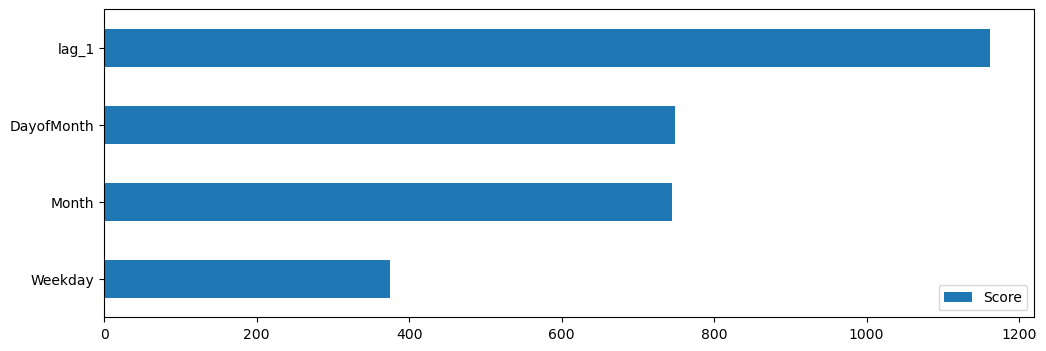

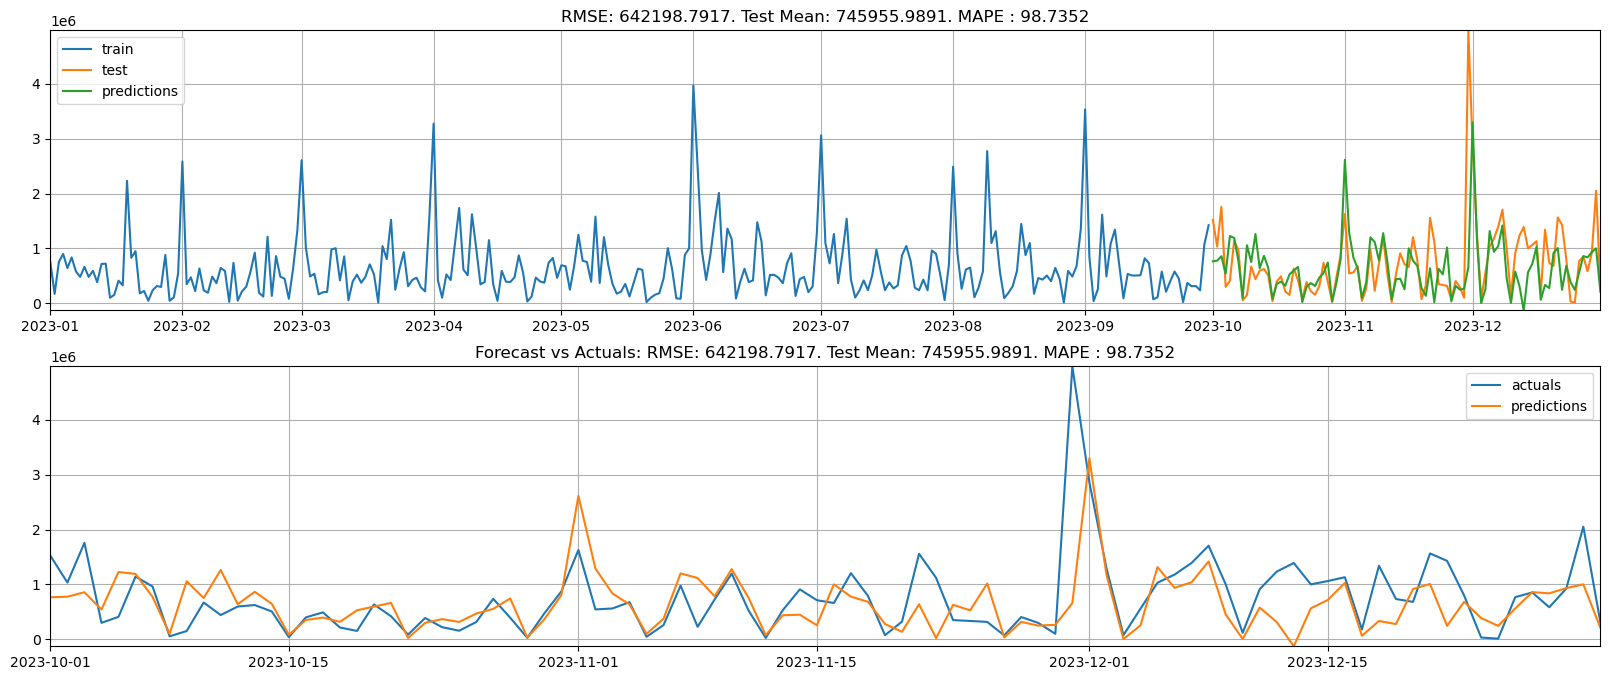

In [260]:
error_rms, mape, predictions, _ = xgboost_prediction(X_train, y_train, X_test, y_test)
df_evaluation = pd.concat(
    [
        df_evaluation
        ,pd.DataFrame(
            data = {"Model_Name" : "Baseline XGBoost", "rmse" : error_rms, "mape" : mape}
            ,index = [3]
            )
    ]
    ,axis = 0
)

In [261]:
df_evaluation

,Model_Name,rmse,mape
0,Holt-Winter's,729014.6006,247.73
1,Baseline Prophet,633254.3342,165.4861
2,Parameter Tuned Prophet,699024.0829,408.3778
2,Parameter Tuned Prophet,628595.9245,167.6848
3,Baseline XGBoost,642198.7917,98.7352


### Hyperparameter tune XGBoost

In [262]:
def xgboost_hyperparameter_tuning(X_train, y_train):

  cv_split = TimeSeriesSplit()

  model = XGBRegressor()

  parameters = {
    "max_depth": [3, 4, 6, 5, 10],
    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
    "n_estimators": [100, 300, 500, 700, 900, 1000],
    "colsample_bytree": [0.3, 0.5, 0.7]
  }

  grid_search = GridSearchCV(estimator = model, cv = cv_split, param_grid = parameters)
  grid_search.fit(X_train, y_train)

  return(pd.DataFrame(data = grid_search.best_params_, index = [0]))

In [263]:
%%time
best_params = xgboost_hyperparameter_tuning(X_train, y_train)

CPU times: total: 1h 15min 37s
Wall time: 19min 41s


In [264]:
best_params

,colsample_bytree,learning_rate,max_depth,n_estimators
0,0.7,0.01,3,500


Parameters provided


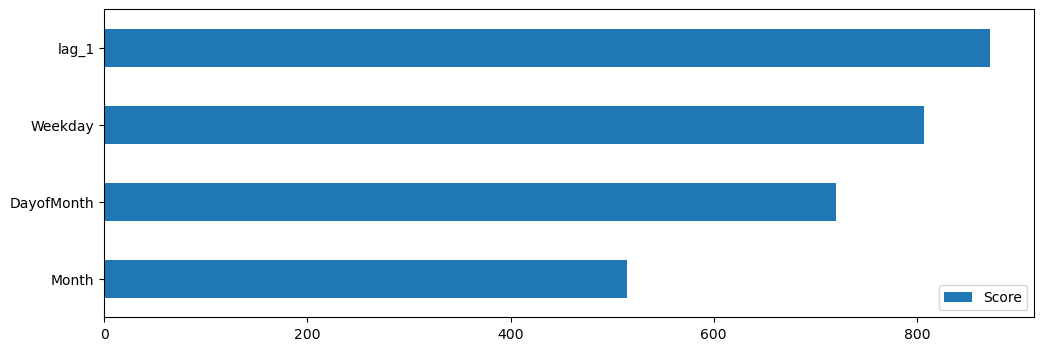

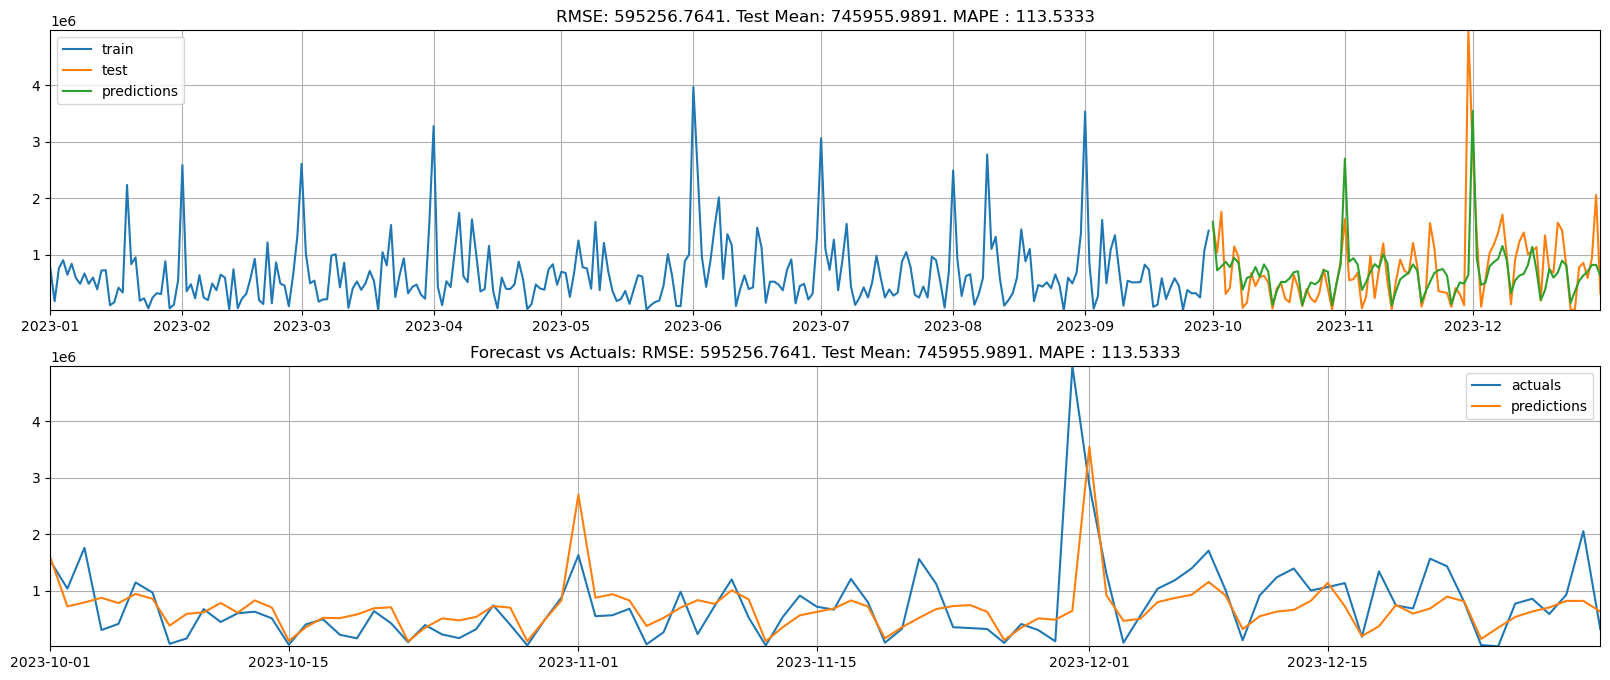

In [265]:
error_rms, mape, predictions, _ = xgboost_prediction(X_train, y_train, X_test, y_test, kwargs = best_params)
df_evaluation = pd.concat(
    [
        df_evaluation
        ,pd.DataFrame(
            data = {"Model_Name" : "Parameter Tuned XGBoost", "rmse" : error_rms, "mape" : mape}
            ,index = [4]
            )
    ]
    ,axis = 0
)

In [266]:
df_evaluation

,Model_Name,rmse,mape
0,Holt-Winter's,729014.6006,247.73
1,Baseline Prophet,633254.3342,165.4861
2,Parameter Tuned Prophet,699024.0829,408.3778
2,Parameter Tuned Prophet,628595.9245,167.6848
3,Baseline XGBoost,642198.7917,98.7352
4,Parameter Tuned XGBoost,595256.7641,113.5333
